In [2]:
import pandas as pd
import missingno as msno
import re
from pathlib import Path
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
tqdm.pandas()

First, let's read read and combine the rows from all blocks into a single dataframe:

In [3]:
data_path = Path("../data")
daily_data_path = data_path/"daily_dataset"

In [4]:
# Read the day, LCLid and energy_sum columns from all blocks and combine

block_df_l = []

for file in tqdm(sorted(list(daily_data_path.glob("*.csv"))), desc="processing blocks..."):
    block_number = re.search(r"block_(\d+)\.csv", str(file)).group(1)
    block_df = pd.read_csv(file, usecols=['day', 'LCLid', 'energy_sum'])
    block_df['day'] = pd.to_datetime(block_df['day'], yearfirst=True)
    block_df['block_number'] = int(block_number)
    block_df_l.append(block_df)

block_df = pd.concat(block_df_l)
del block_df_l

processing blocks...:   0%|          | 0/112 [00:00<?, ?it/s]

In [5]:
block_df.head()

,LCLid,day,energy_sum,block_number
0,MAC000002,2012-10-12,7.098,0
1,MAC000002,2012-10-13,11.087,0
2,MAC000002,2012-10-14,13.223,0
3,MAC000002,2012-10-15,10.257,0
4,MAC000002,2012-10-16,9.769,0


### Inspecting the data

We can see that the number of unique households in the dataset varies over time. 

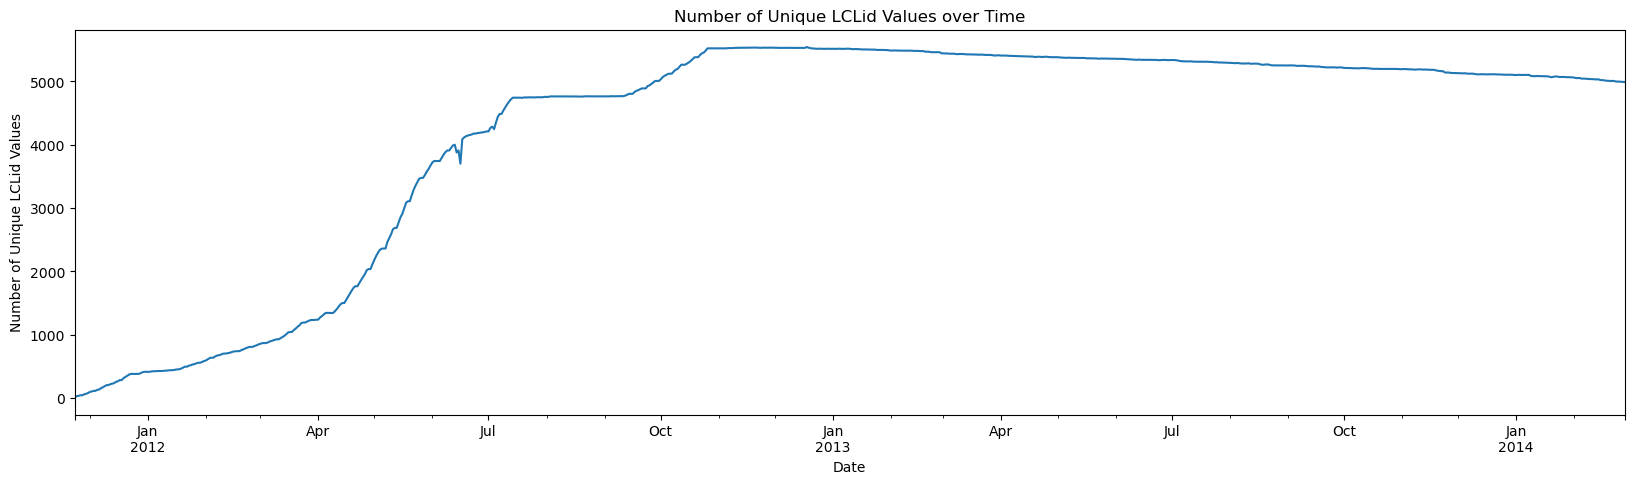

In [6]:
housecount = block_df.groupby('day')[['LCLid']].nunique()

# Plot the number of unique 'LCLid' values over time
housecount.plot(kind='line', figsize=(20,5), legend=None)
plt.title('Number of Unique LCLid Values over Time')
plt.xlabel('Date')
plt.ylabel('Number of Unique LCLid Values')
plt.legend
plt.show()

We can use the missingno package to highlight which households are missing days. Looking at households in just the first block:

<Axes: >

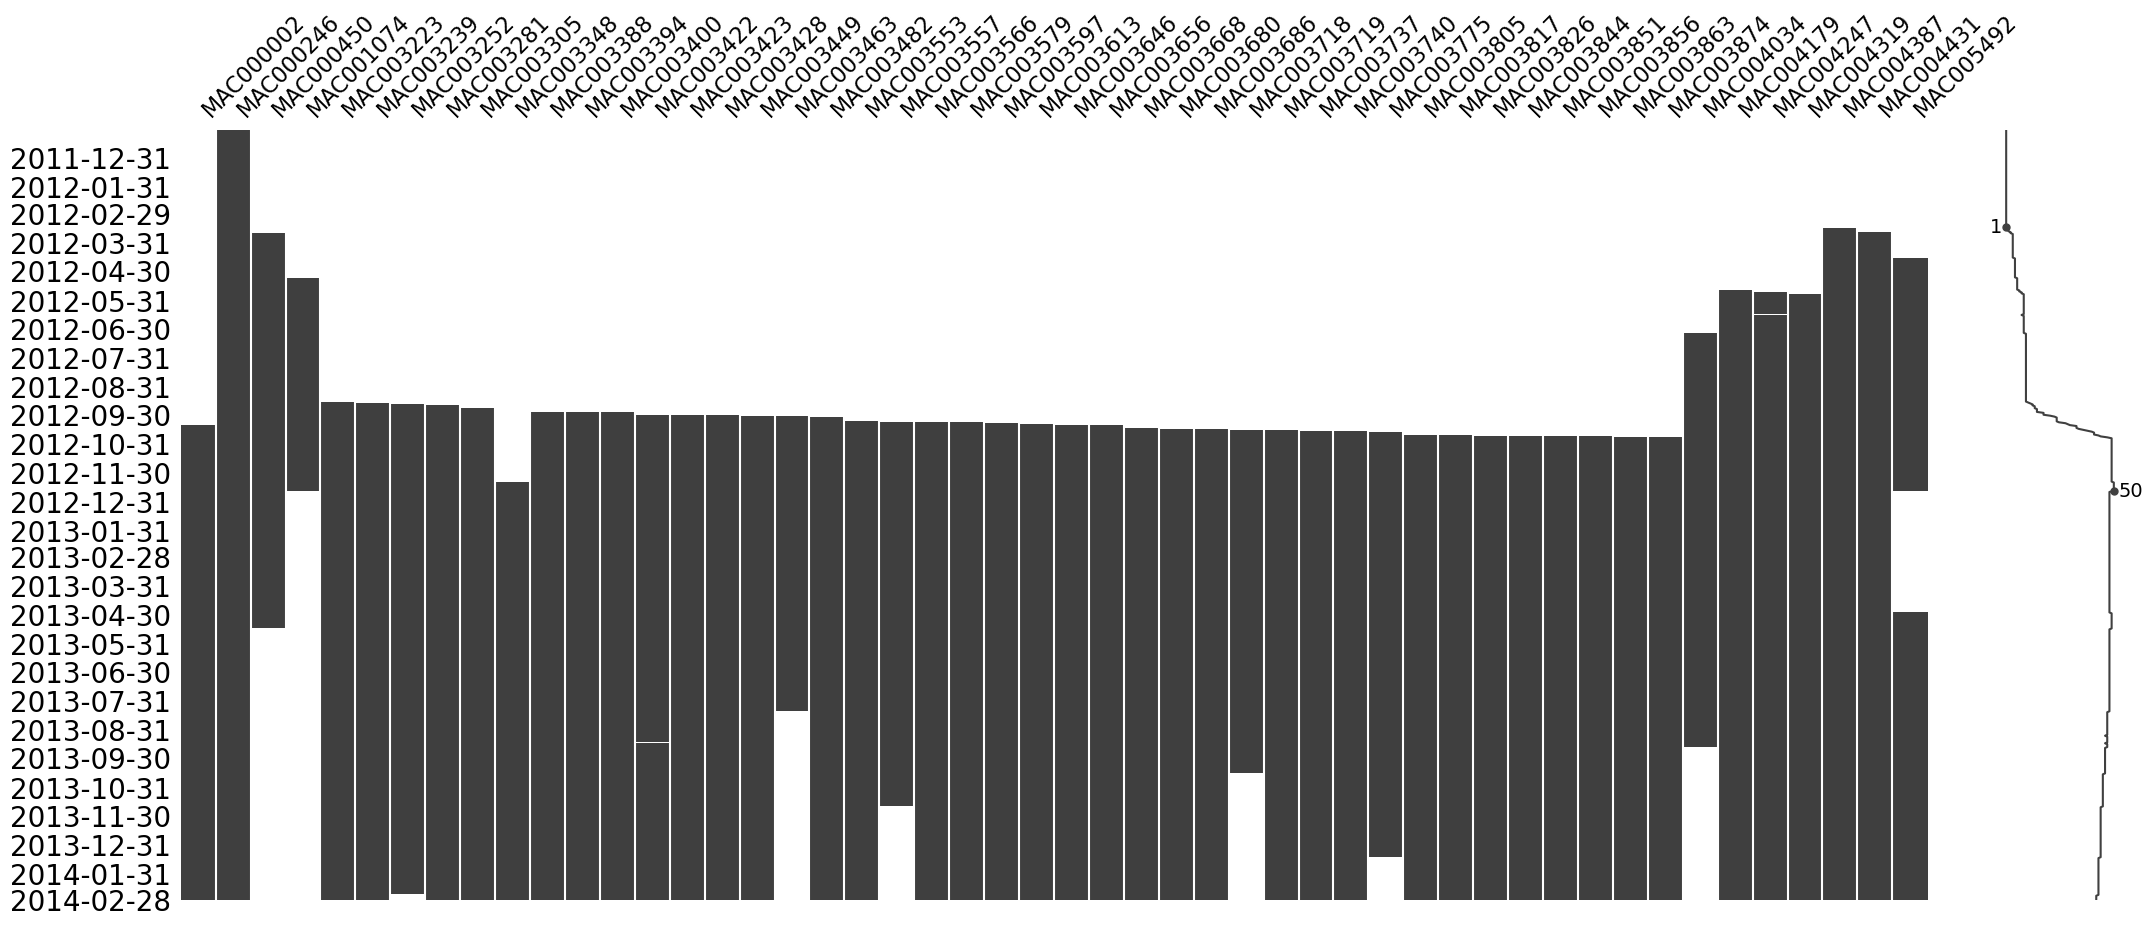

In [7]:
# Highlight the missing days for households in the first block
plot_df = pd.pivot_table(block_df[block_df['block_number'] == 0], index="day", 
columns="LCLid", values="energy_sum")
msno.matrix(plot_df, freq="M")

This visualisation tells us that:
- The time series are not perfectly aligned: data collection for some consumers starts and ends earlier than others, where households either stopped being consumers of measurements stopped.
- There are some small gaps which represent missing values.

The data collection across households is inconsistent, which would be problematic if we were interested in prediction energy consumption at the household level.

### Normalising the data

In [8]:
# Group by 'day' and calculate sum and mean
energy_df = (
    block_df
    .groupby('day')['energy_sum']
    .agg(['sum', 'mean'])
    .rename(columns={'sum': 'total_energy', 'mean': 'average_energy'})
    .reset_index()
)

In [9]:
energy_df.head()

,day,total_energy,average_energy
0,2011-11-23,90.385000,6.952692
1,2011-11-24,213.412000,8.536480
2,2011-11-25,303.993000,9.499781
3,2011-11-26,420.976000,10.267707
4,2011-11-27,444.883001,10.850805


In [10]:
energy_df.dtypes

day               datetime64[ns]
total_energy             float64
average_energy           float64
dtype: object

`weather_daily_darksky.csv` contains daily weather data for London from the [darksky api](https://darksky.net/dev).

In [11]:
weather_data_path = data_path/"weather_daily_darksky.csv"

columns_of_interest = ['temperatureMax', 'windBearing', 'dewPoint', 'cloudCover', 'windSpeed',
       'pressure', 'apparentTemperatureHigh', 'visibility', 'humidity',
       'apparentTemperatureLow', 'apparentTemperatureMax', 'uvIndex',
       'temperatureLow', 'temperatureMin', 'temperatureHigh',
       'apparentTemperatureMin', 'moonPhase','time']

# weather_df = (
#     pd.read_csv(weather_data_path, 
#                 usecols=columns_of_interest,
#                 parse_dates=['time'], 
#                 date_format="%Y-%m-%d %H:%M:%S")
#     .rename(columns={'time': 'day'})
# )

weather_df = (
    pd.read_csv(weather_data_path, 
                usecols=columns_of_interest)
    .rename(columns={'time': 'day'})
)

# Weather data day column shifts by an hour when entering/leaving British Summer time.
# Here, we alter the timestamps so that they're all at midnight (so that we can join with
# energy dataframe)
weather_df['day'] = (
    pd.to_datetime(weather_df['day'])
    .dt.tz_localize('GMT')
    .dt.tz_convert('Europe/London')
    .dt.tz_localize(None)
)

In [12]:
weather_df.dtypes

temperatureMax                    float64
windBearing                         int64
dewPoint                          float64
cloudCover                        float64
windSpeed                         float64
pressure                          float64
apparentTemperatureHigh           float64
visibility                        float64
humidity                          float64
apparentTemperatureLow            float64
apparentTemperatureMax            float64
uvIndex                           float64
day                        datetime64[ns]
temperatureLow                    float64
temperatureMin                    float64
temperatureHigh                   float64
apparentTemperatureMin            float64
moonPhase                         float64
dtype: object

### Merging energy and weather data

In [13]:
energy_weather_df = energy_df.merge(weather_df, on='day')

### Bank holidays

`uk_bank_holidays.csv` contains the dates and kinds of several UK bank holidays which occurred during the dataset timeframe (and a few which occured after the end of the time series). Energy consumption patterns might be different on a holiday when members of a household are in/out of the house when they wouldn't normally be.

Here, we add an `is_holiday` flag to our combined weather and energy dataframe.

In [14]:
# Read in holiday list
holiday_data_path = data_path/"uk_bank_holidays.csv"
holiday_df = pd.read_csv(holiday_data_path)
holiday_df['Bank holidays'] = pd.to_datetime(holiday_df['Bank holidays'], format='%Y-%m-%d')

In [23]:
# Add flag to indicate whether a date in the combined time series is a holiday or not (1 or 0)
energy_weather_df['is_holiday'] = energy_weather_df['day'].isin(holiday_df['Bank holidays'].tolist()).astype(int)

In [202]:
# Save the combined energy and weather data for analysis
output_path = data_path/"output/energy_weather_data.parquet"
energy_weather_df.to_parquet(output_path)